In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV,KFold,cross_val_score,StratifiedKFold
from sklearn.svm import SVC,LinearSVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn import metrics
from statsmodels.stats.multitest import multipletests
from sklearn.multiclass import OneVsRestClassifier
from statsmodels import api as sm
from statsmodels.formula.api import ols
from bioinfokit. analys import stat as bk_stat
from sklearn.metrics import roc_auc_score
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import signal,stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.trials.spikes import firing_rate,sp_constants
from ephysvibe.trials import select_trials
from ephysvibe.spike_sorting import config
from ephysvibe.structures.trials_data import TrialsData
from ephysvibe.trials.spikes import firing_rate
from ephysvibe.task import task_constants,def_task
import os 
from matplotlib import cm
seed = 2023

In [2]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
    count = 0
    for i_step in np.arange(0,d_shape[1]-step,step):
        d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
        count +=1
    return d_avg

In [3]:
def scale_p(x, out_range=(-1, 1)):
    domain = 0, 1
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [4]:
def compute_roc_auc(group1,group2):
    #roc_score:Dict[str,list] = defaultdict(list)
    scaler = MinMaxScaler(feature_range=(-1,1))
    scaler.fit(np.arange(0,1,0.1).reshape(-1, 1))
    rng = np.random.default_rng(seed=seed)
    #it_seed = rng.integers(low=1, high=2023, size=a.shape[1], dtype=int)
    roc_score = []
    p = []
    for n_win in np.arange(group1.shape[1]):
        # if n_win == 316:
        #     print(n_win)
        g1 = group1[:,n_win]
        g2 = group2[:,n_win]
        # Wilcoxon rank-sum 
        p.append(stats.ranksums(g1, g2)[1])#stats.ttest_ind
        min_fr, max_fr = np.concatenate([g1,g2]).min(),np.concatenate([g1,g2]).max()

        thresholds = np.unique(np.concatenate([g1,g2]))#np.arange(min_fr,max_fr+0.01,0.01)
        y_g1, y_g2 = np.ones(len(g1)),np.zeros(len(g2))
        score=0.5
        fpr,tpr=[],[]
        for threshold in thresholds:
            g1_y_pred,g2_y_pred = np.zeros(len(g1)),np.zeros(len(g2))
            g1_mask,g2_mask = g1>=threshold,g2>=threshold
            g1_y_pred[g1_mask],g2_y_pred[g2_mask] = 1,1
            tp = sum(np.logical_and(y_g1==1,g1_y_pred==1))
            fn = sum(np.logical_and(y_g1==1,g1_y_pred==0))
            tpr.append(tp/ (tp+fn) )
            fp = sum(np.logical_and(y_g2==0,g2_y_pred==1))
            tn = sum(np.logical_and(y_g2==0,g2_y_pred==0))
            fpr.append(fp/ (fp+tn) )
        if len(fpr) > 1:
            fpr,tpr=np.array(fpr),np.array(tpr)
            idx_sort=fpr.argsort()
            score = metrics.auc(fpr[fpr.argsort()],tpr[tpr.argsort()])
            roc_score.append(score)
        else:
            roc_score.append(score)
    roc_score = np.array(roc_score)
    roc_score = scale_p(np.round(roc_score,2))#scaler.transform(np.round(roc_score,2).reshape(-1, 1)).squeeze()
    return roc_score,p


In [41]:

def get_mag_ang(data,i_neuron):
    t_before = 200
    t_after = 950
    in_out='in'
    trials_b1 = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]
    shifts = data.code_samples[
        trials_b1,
        np.where(data.code_numbers[trials_b1] == task_constants.EVENTS_B1["sample_on"])[
            1
        ],
    ]-t_before

    roll_sp = TrialsData.indep_roll(data.sp_samples[trials_b1,i_neuron],shifts=-shifts.astype(int), axis=1)[:,:t_after+t_before]
    if np.any(np.isnan(data.neuron_cond)):
        neuron_cond = np.ones(len(data.clustersgroup))
    else:
        neuron_cond=data.neuron_cond
    task = def_task.create_task_frame(
        condition=data.condition[trials_b1],
        test_stimuli=data.test_stimuli[trials_b1],
        samples_cond=task_constants.SAMPLES_COND,
        neuron_cond = neuron_cond,
    )
    task = task[(task['i_neuron']==i_neuron)&(task['in_out']==in_out)]

    c1_trials = task[task['sample'].str.contains('c1', case=False)]['trial_idx'].values
    c5_trials = task[task['sample'].str.contains('c5', case=False)]['trial_idx'].values
    o1_trials = task[task['sample'].str.contains('o1', case=False)]['trial_idx'].values
    o5_trials = task[task['sample'].str.contains('o5', case=False)]['trial_idx'].values
    c0_trials = task[task['sample'].str.contains('c0', case=False)]['trial_idx'].values

    win = 150#100
    step = 1
    avg_sp = moving_average(data=roll_sp,win=win, step=step)[:,:-win]

    c1_sp = avg_sp[c1_trials] 
    c5_sp = avg_sp[c5_trials] 
    o1_sp = avg_sp[o1_trials] 
    o5_sp = avg_sp[o5_trials] 
    #c0_sp = avg_sp[c0_trials] 

    color,p_color = compute_roc_auc(c1_sp,c5_sp)
    orient,p_orient = compute_roc_auc(o1_sp,o5_sp)

    x = color
    y = orient
    mag = np.sqrt(x**2+y**2)
    ang = np.arctan2(y,x)*180/np.pi
    ang = np.where(ang >=0,ang,ang+360)

    return mag,ang,color,orient,p_color,p_orient

In [42]:
file1 = open("/home/INT/losada.c/Documents/codes/run_pipelines/paths_decoding.txt", "r")
Lines = file1.readlines()

In [43]:
paths=[]
for line in Lines:
    paths.append(line.strip())
print(paths[0])

/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/pfc/2023-01-20_11-00-24_Riesling_pfc_e1_r1.h5


In [44]:
for path in paths:
    s_path = os.path.normpath(path).split(os.sep)

In [45]:
paths

['/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/pfc/2023-01-20_11-00-24_Riesling_pfc_e1_r1.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/pfc/2023-01-23_10-10-27_Riesling_pfc_e1_r1.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/pfc/2022-12-14_10-50-49_Riesling_pfc_e1_r1.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/pfc/2023-02-08_10-39-41_Riesling_pfc_e1_r1.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/pfc/2022-12-05_10-51-52_Riesling_pfc_e1_r1.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/pfc/2022-12-01_12-01-59_Riesling_pfc_e1_r1.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/Riesling/pfc/2022-12-06_11-12-04_Riesling_pfc_e1_r1.h5',
 '/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_

In [46]:
all_mag,all_ang,all_color,all_orient,neuron,p_color_all,p_orient_all = [],[],[],[],[],[],[]
for path in paths:
    data = TrialsData.from_python_hdf5(path)
    s_path = os.path.normpath(path).split(os.sep)
    i_good, i_mua = 1, 1
    for i_neuron,cluster in enumerate(data.clustersgroup):

        if cluster == "good":
            i_cluster = i_good
            i_good += 1
            cluster = "neuron"

            mag,ang,color,orient,p_color,p_orient = get_mag_ang(data,i_neuron)
            all_mag.append(mag)
            all_ang.append(ang)
            all_color.append(color)
            all_orient.append(orient)
            p_color_all.append(p_color)
            p_orient_all.append(p_orient)
            neuron.append(cluster+str(i_cluster)+'_'+s_path[-1][:-3])

        else:
            i_cluster = i_mua
            i_mua += 1


In [11]:
# all_mag,all_ang,all_color,all_orient,neuron,p_color_all,p_orient_all = [],[],[],[],[],[],[]
# i_good, i_mua = 1, 1
# for i_neuron,cluster in enumerate(data.clustersgroup):
#     #if i_neuron == 24:
#     if cluster == "good":
#         i_cluster = i_good
#         i_good += 1
#         cluster = "neuron"
#     else:
#         i_cluster = i_mua
#         i_mua += 1
#     mag,ang,color,orient,p_color,p_orient = get_mag_ang(data,i_neuron)
#     all_mag.append(mag)
#     all_ang.append(ang)
#     all_color.append(color)
#     all_orient.append(orient)
#     p_color_all.append(p_color)
#     p_orient_all.append(p_orient)
#     neuron.append(cluster+str(i_cluster)+'_'+s_path[-1][:-3])

In [31]:
np.save(s_path[-2]+'/'+s_path[-2]+'_150_mag', arr=np.array(all_mag))
np.save(s_path[-2]+'/'+s_path[-2]+'_150_ang', arr=np.array(all_ang))
np.save(s_path[-2]+'/'+s_path[-2]+'_150_p_color', arr=np.array(p_color_all))
np.save(s_path[-2]+'/'+s_path[-2]+'_150_p_orient', arr=np.array(p_orient_all))
np.save(s_path[-2]+'/'+s_path[-2]+'_150_neuron', arr=np.array(neuron))

In [32]:
all_mag = np.load(s_path[-2]+'/'+s_path[-2]+'_150_mag.npy')
all_ang = np.load(s_path[-2]+'/'+s_path[-2]+'_150_ang.npy')
p_color_all = np.load(s_path[-2]+'/'+s_path[-2]+'_150_p_color.npy')
p_orient_all = np.load(s_path[-2]+'/'+s_path[-2]+'_150_p_orient.npy')
neuron = np.load(s_path[-2]+'/'+s_path[-2]+'_150_neuron.npy')

In [33]:
def scale_mag(x, out_range=(0.05, 1)):
    domain = 0.2, 1
    y = (x - (domain[1] + domain[0]) / 2) / (domain[1] - domain[0])
    return y * (out_range[1] - out_range[0]) + (out_range[1] + out_range[0]) / 2

In [34]:
quant_steps=360*4
cmap=cm.get_cmap('hsv',quant_steps)

f_all_mag=np.where(np.array(all_mag)>1,1.,np.array(all_mag))
lim = 0.2
mask=f_all_mag<lim
f_all_mag = scale_mag(f_all_mag)
f_all_mag = np.where(f_all_mag<0,0,f_all_mag)

In [35]:
def find_significant(p_value:np.ndarray,win:int, step:int=1)-> np.ndarray:

    p_shape=p_value.shape
    sign = np.zeros((p_shape[0],int(np.floor(p_shape[1]/step))))
    count = 0
    for i_step in np.arange(0,p_shape[1]-step,step):
        sign[:,count] = np.where(np.all(p_value[:,i_step:i_step+win]<0.01,axis=1),True,False)
        #sign[:,count] = np.where((np.sum(p_color_all[:,i_step:i_step+win]<0.01,axis=1)>=30),True,False)
        count +=1
    return sign

In [37]:
step=1
win=100
s_color = find_significant(p_value=p_color_all,win=win, step=step)
s_orient = find_significant(p_value=p_orient_all,win=win, step=step)

no_sig = np.where(np.sum(s_orient,axis=1)==0)[0]
if len(no_sig)!=0:
    s_orient[no_sig,-1]=np.nan
no_sig = np.where(np.sum(s_color,axis=1)==0)[0]
if len(no_sig)!=0:
    s_color[no_sig,-1]=np.nan

orient_max = np.nanargmax(s_orient,axis=1)
orient_max=np.where(np.logical_and(orient_max==0,np.isnan(s_orient[:,-1])),np.nan,orient_max)
color_max = np.nanargmax(s_color,axis=1)
color_max=np.where(np.logical_and(color_max==0,np.isnan(s_color[:,-1])),np.nan,color_max)

In [38]:
i_neu=34
neuron[idx_c_o_sort][i_neu]

IndexError: index 274 is out of bounds for axis 0 with size 274

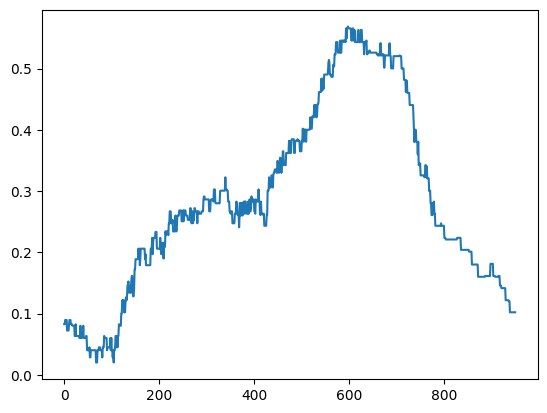

In [39]:
plt.plot(all_mag[idx_c_o_sort[i_neu]])

/tmp/ipykernel_78160/3140130003.py:4: RuntimeWarning: All-NaN axis encountered
  c_o_max = np.nanmin([color_max,orient_max],axis=0)


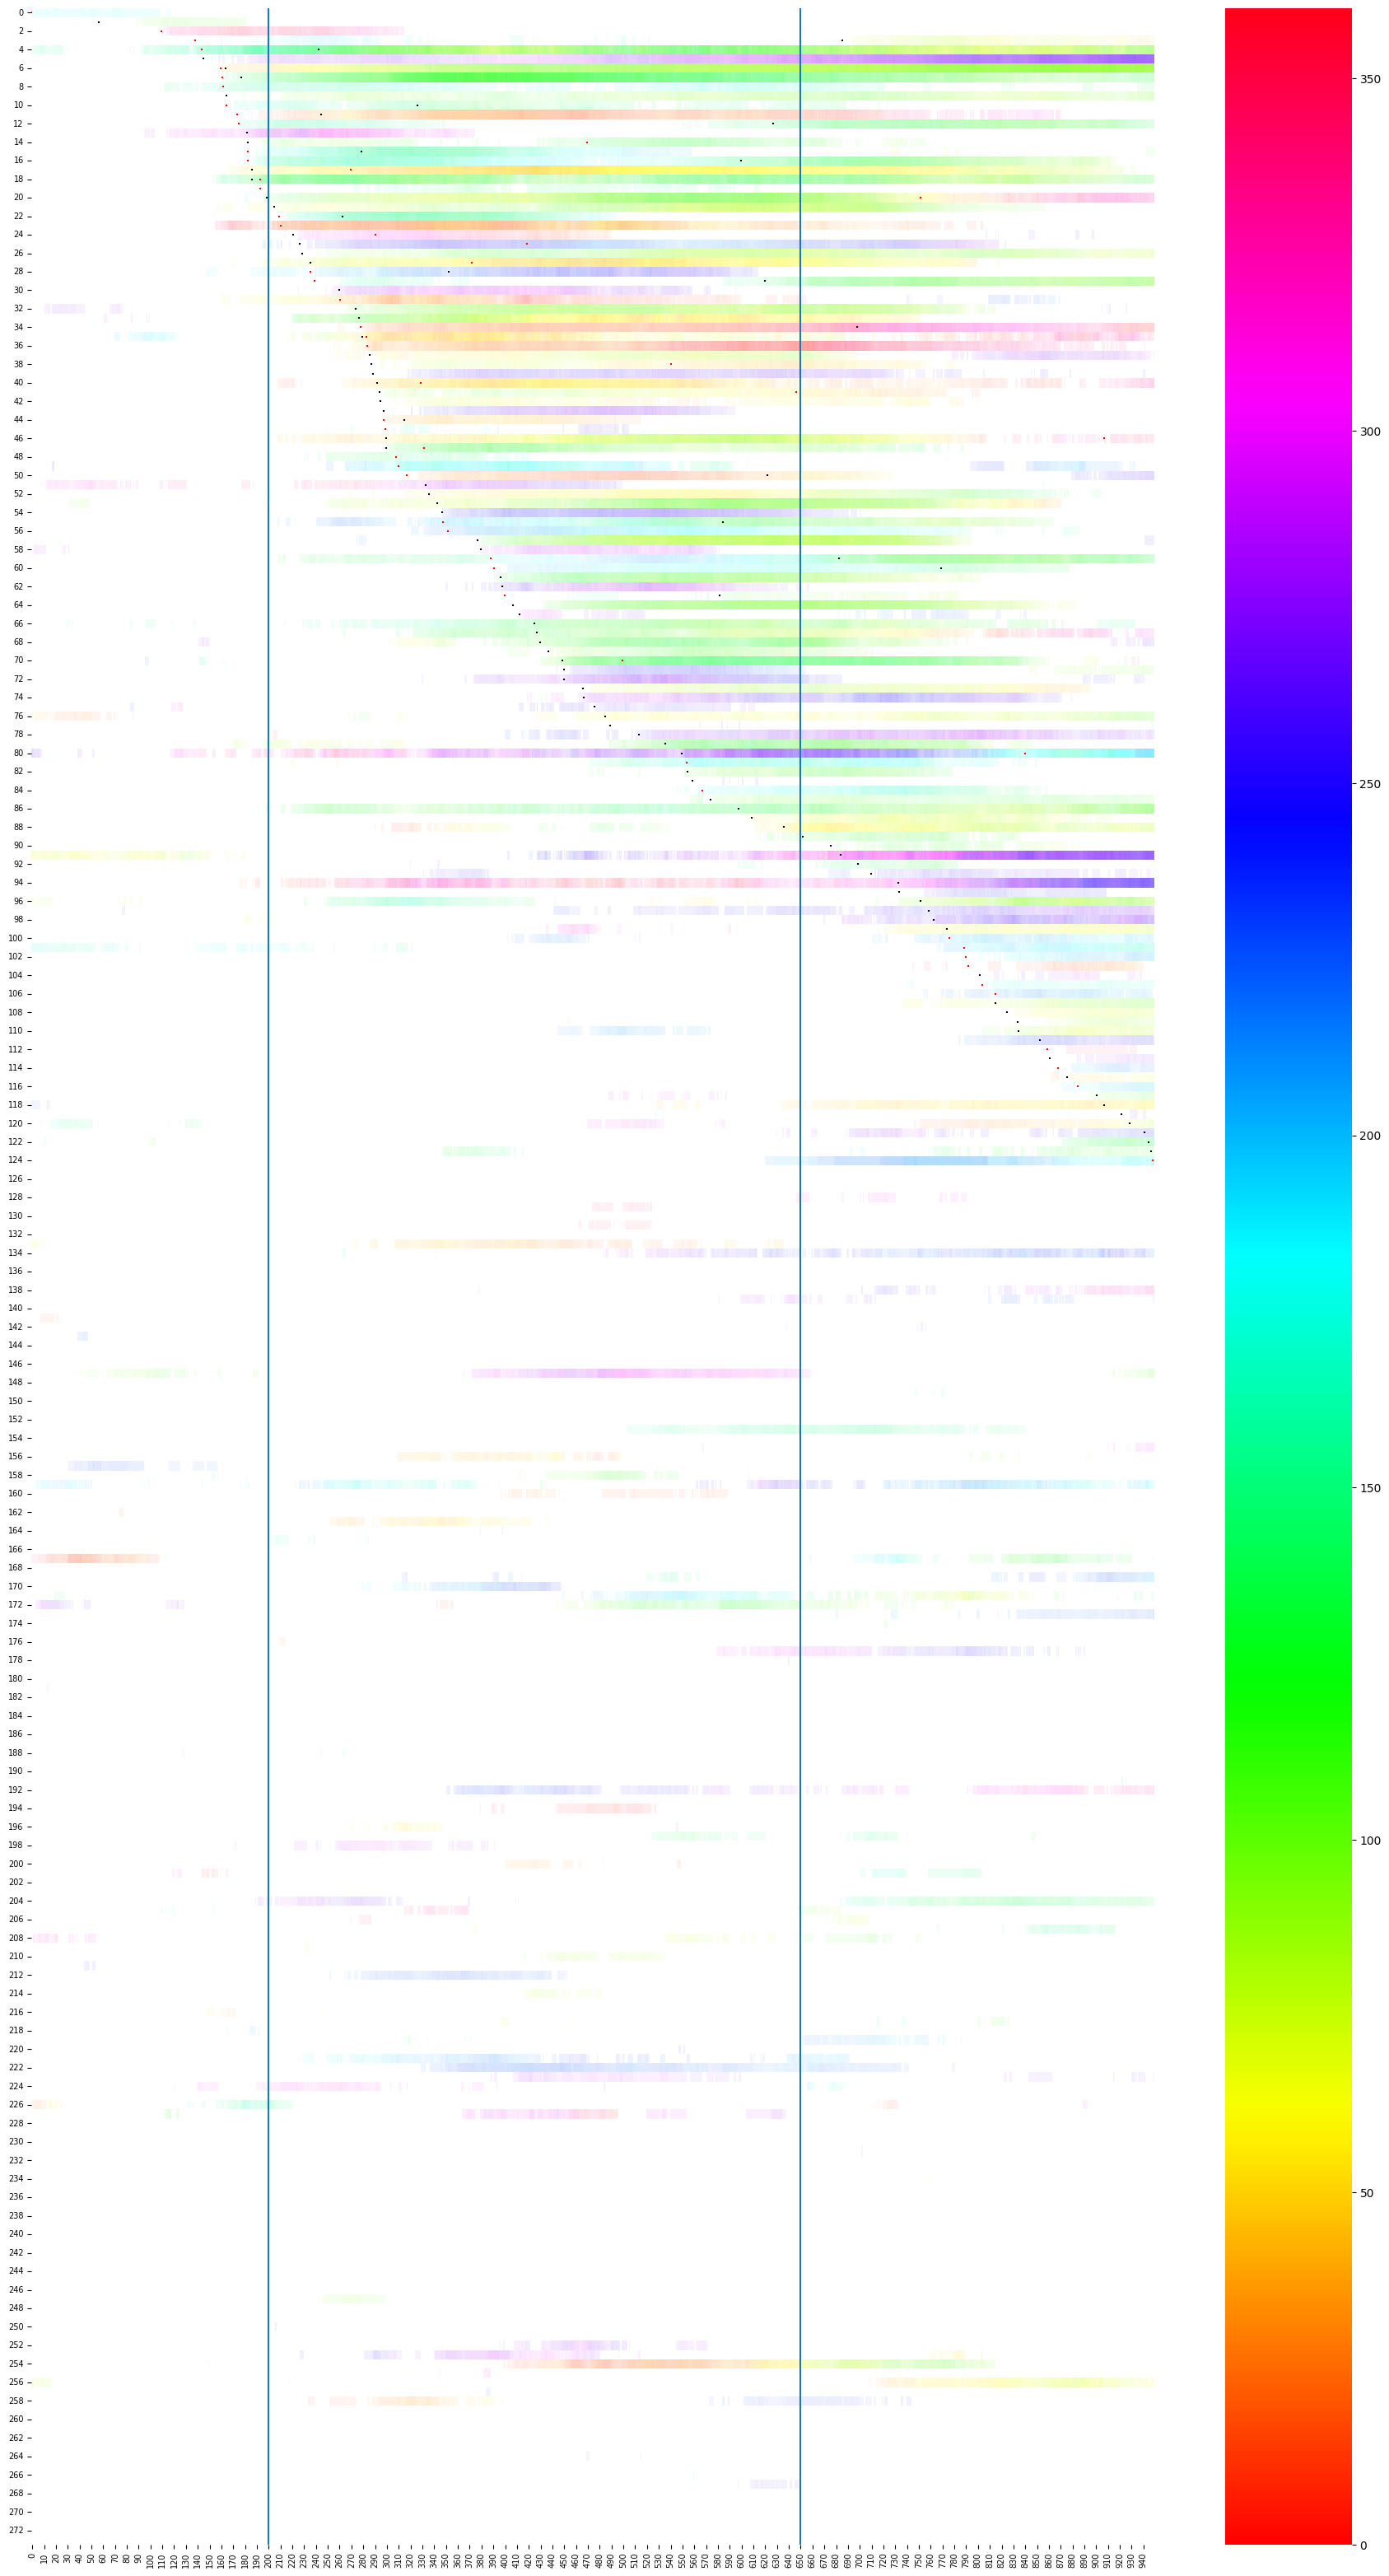

In [40]:
c_o_mask = np.argmin([color_max,orient_max],axis=0)
c_mask = c_o_mask==0
o_mask = c_o_mask == 1
c_o_max = np.nanmin([color_max,orient_max],axis=0)
idx_c_o_sort = np.argsort(c_o_max)
#idx_c_o_sort=idx_c_o_sort[c_o_max[idx_c_o_sort]!=0]

fig,ax = plt.subplots(figsize=(22,40))
#ax.vlines([200,650],0,200)
ax = sns.heatmap(np.array(all_ang)[idx_c_o_sort],cmap=cmap,vmin=0,vmax=360,alpha=f_all_mag[idx_c_o_sort],mask=mask[idx_c_o_sort],ax=ax)#,yticklabels=np.arange(len(all_ang[idx_c_o_sort])))

ax.scatter(color_max[idx_c_o_sort],np.arange(len(c_o_max[idx_c_o_sort]))+0.5,marker='|',color='r',label='color',s=4)
ax.scatter(orient_max[idx_c_o_sort],np.arange(len(c_o_max[idx_c_o_sort]))+0.5,marker='|',color='k',label='orientation',s=4)
# ax.set_xticks(np.arange(0,len(all_ang[0]),5).tolist())
# ax.set_xlabel(pp)
ax.tick_params(labelsize=7)
ax.vlines([200,650],0,1075)
#ax.scatter(c_o_max[idx_c_o_sort],np.arange(len(c_o_max[idx_c_o_sort]))+0.5,marker='|')
#ax.set_yticks(np.arange(len(all_ang)))
#g.set_ylabel(np.array(np.arange(len(all_ang)),dtype=str))
# ax.set_xlabel(np.arange(-200,len(all_ang[0])-200))
#fig.legend(fontsize=9)
plt.show()

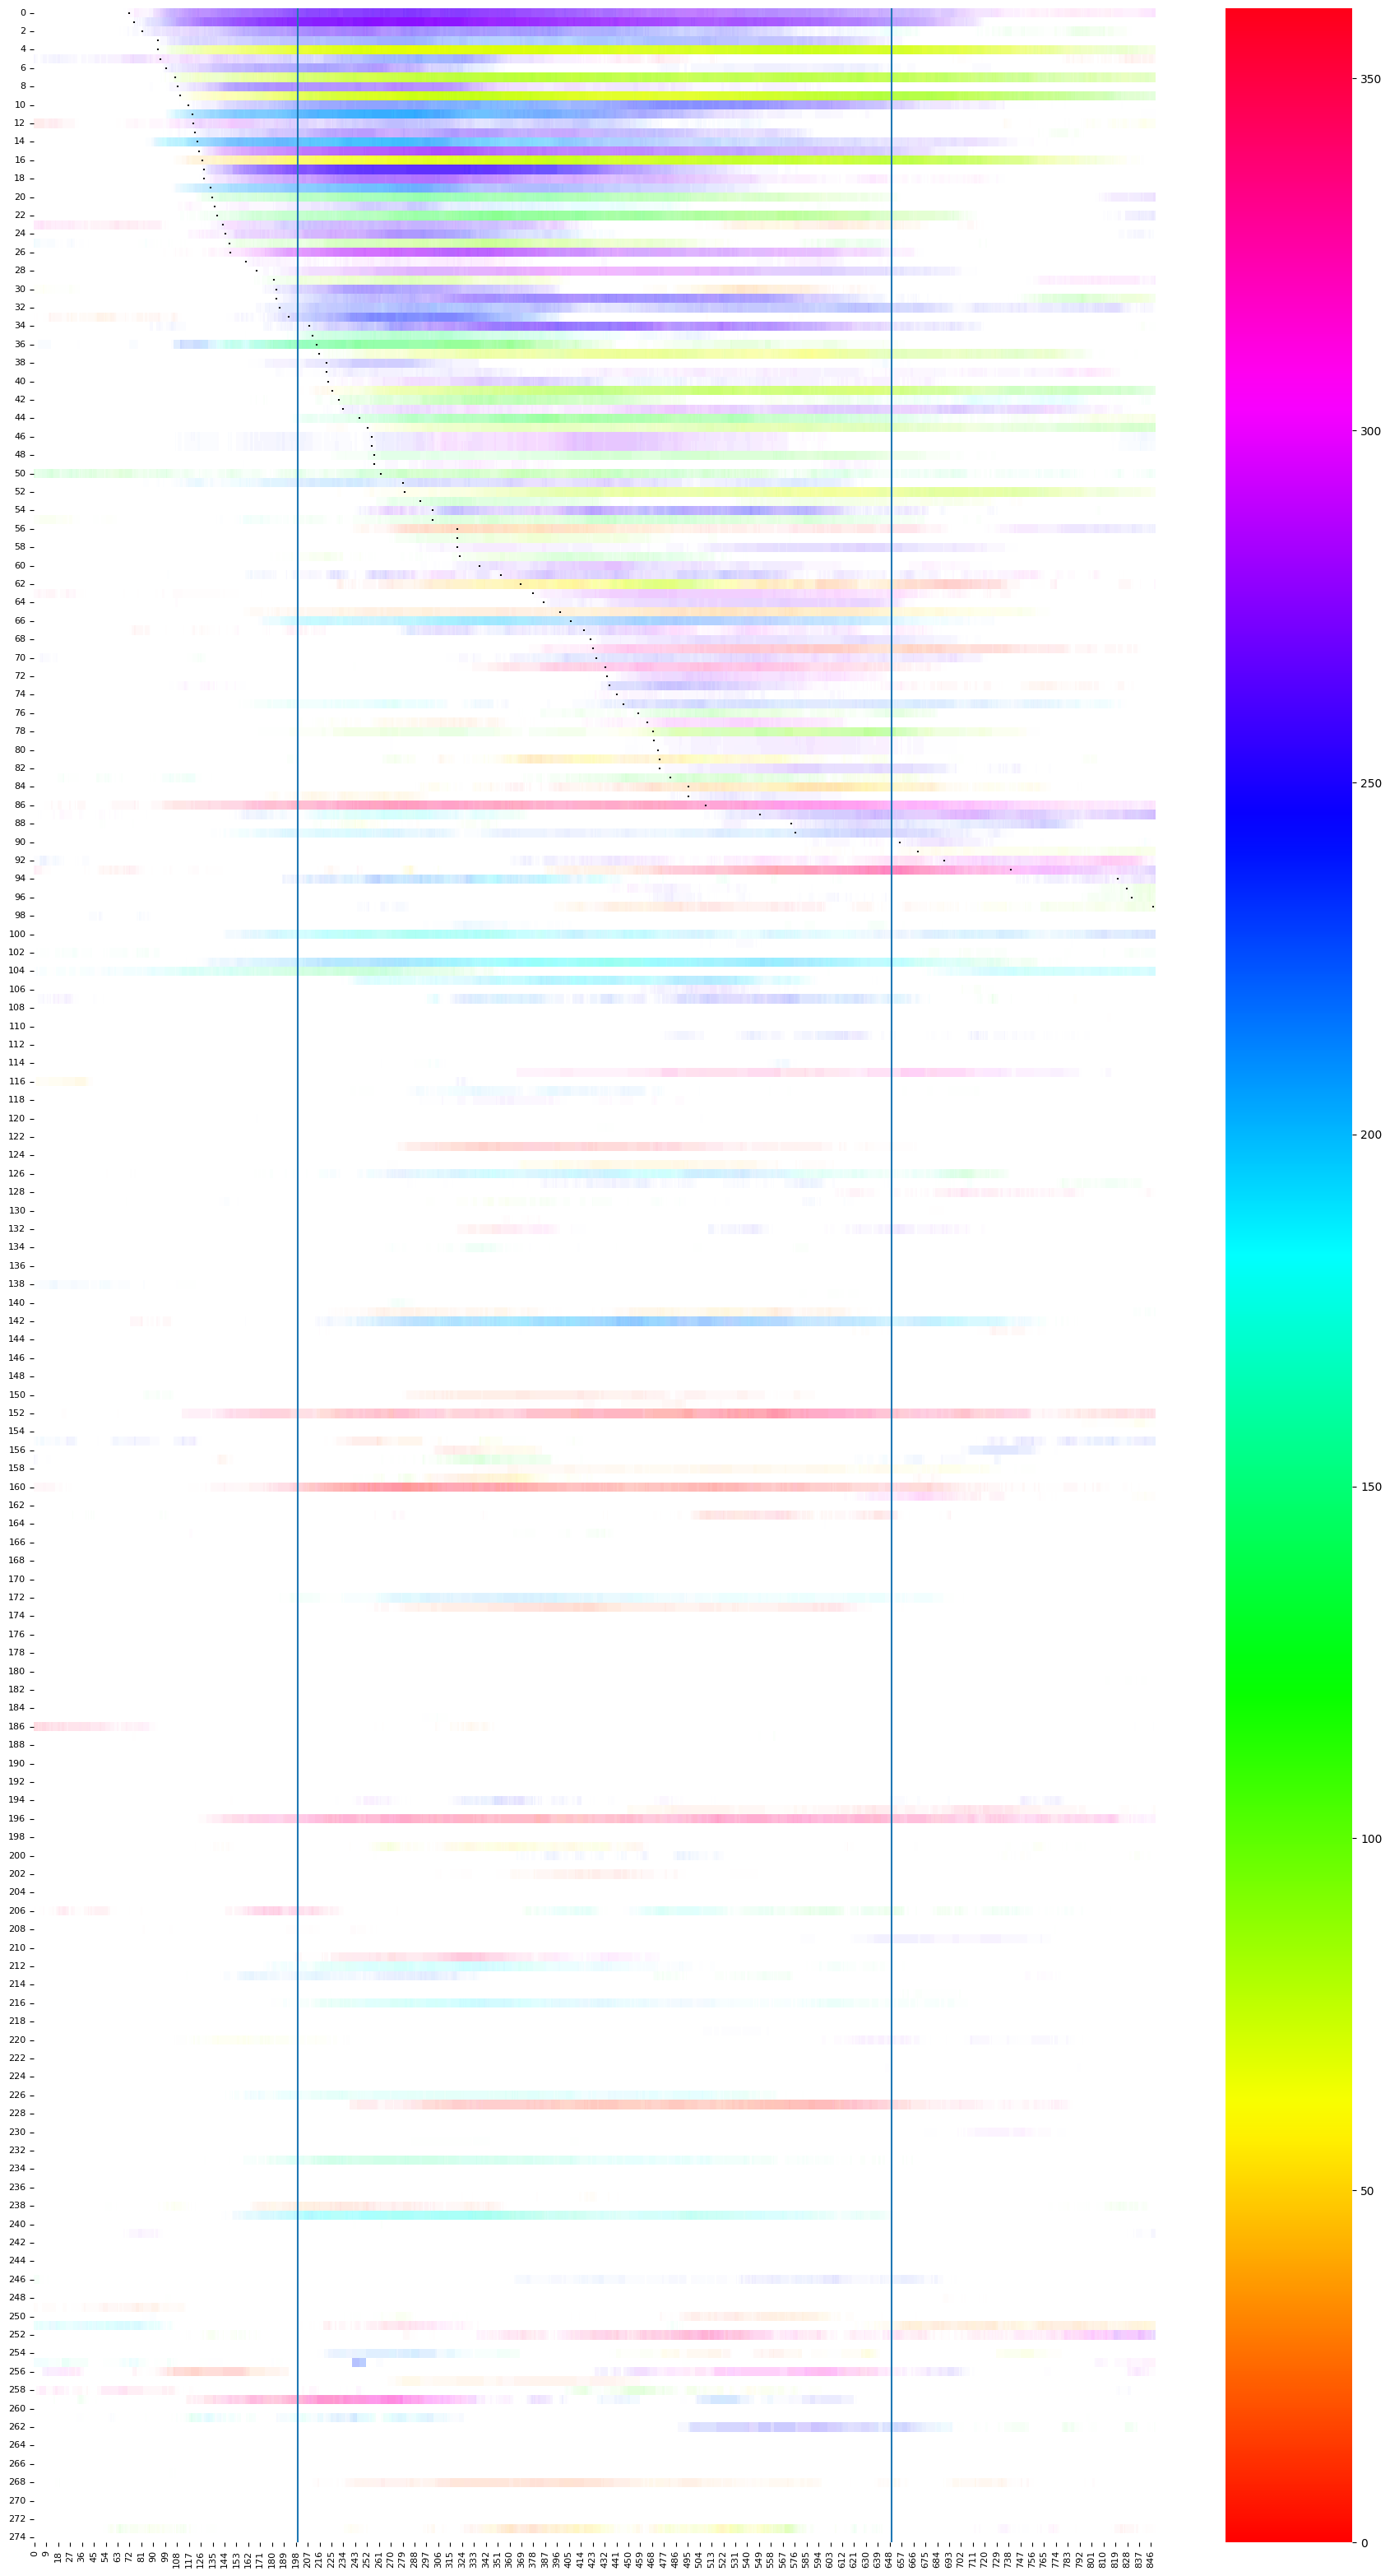

In [24]:
idx_orient_sort = np.argsort(orient_max)
#idx_orient_sort=idx_orient_sort[orient_max[idx_orient_sort]!=0]

fig,ax = plt.subplots(figsize=(22,40))
#ax.vlines([200,650],0,200)
g = sns.heatmap(np.array(all_ang)[idx_orient_sort],cmap=cmap,vmin=0,vmax=360,alpha=f_all_mag[idx_orient_sort],mask=mask[idx_orient_sort],ax=ax)#,yticklabels=np.arange(len(all_ang[idx_orient_sort])))
g.tick_params(labelsize=8)
ax.scatter(orient_max[idx_orient_sort],np.arange(len(orient_max[idx_orient_sort]))+0.5,marker='|',color='k',label='color',s=4)

ax.vlines([200,650],0,1075)
#ax.set_yticks(np.arange(len(all_ang)))
#g.set_ylabel(np.array(np.arange(len(all_ang)),dtype=str))
# ax.set_xlabel(np.arange(-200,len(all_ang[0])-200))
plt.show()

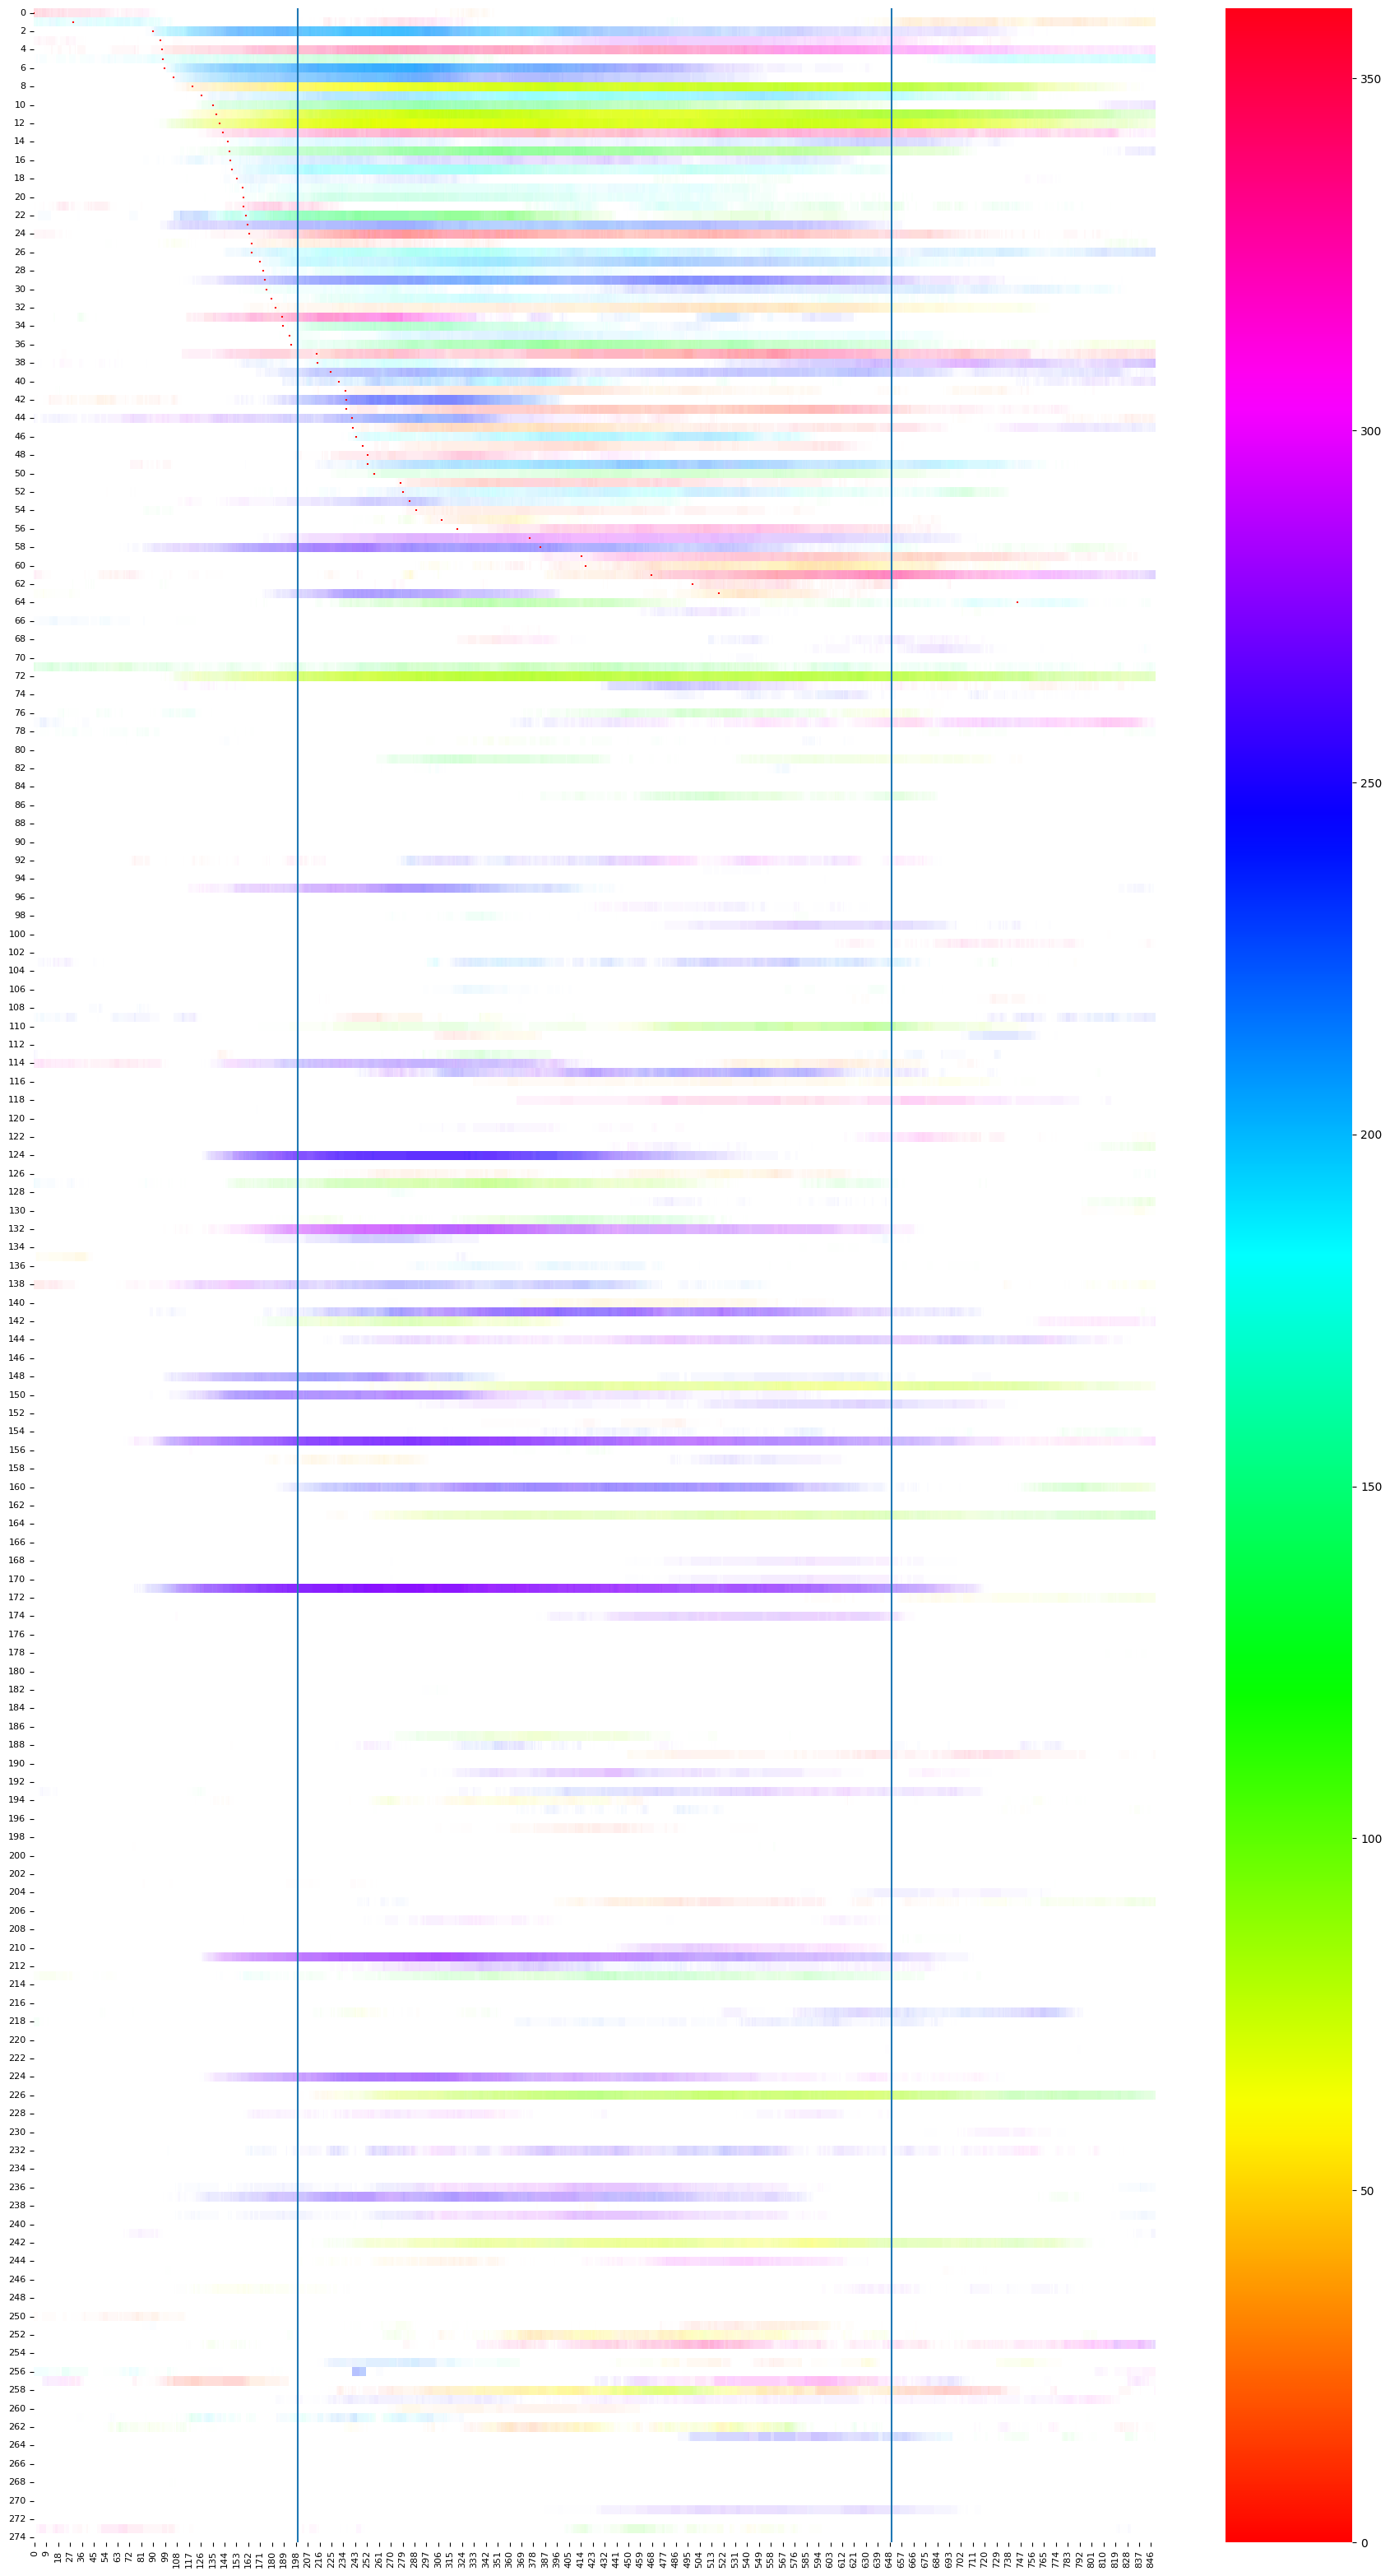

In [25]:
idx_color_sort = np.argsort(color_max)
#idx_color_sort=idx_color_sort[color_max[idx_color_sort]!=0]

fig,ax = plt.subplots(figsize=(22,40))
#ax.vlines([200,650],0,200)
g = sns.heatmap(np.array(all_ang)[idx_color_sort],cmap=cmap,vmin=0,vmax=360,alpha=f_all_mag[idx_color_sort],mask=mask[idx_color_sort],ax=ax)#,yticklabels=np.arange(len(all_ang[idx_color_sort])))
g.tick_params(labelsize=8)
ax.scatter(color_max[idx_color_sort],np.arange(len(color_max[idx_color_sort]))+0.5,marker='|',color='r',label='color',s=4)
ax.vlines([200,650],0,1075)
#ax.set_yticks(np.arange(len(all_ang)))
#g.set_ylabel(np.array(np.arange(len(all_ang)),dtype=str))
# ax.set_xlabel(np.arange(-200,len(all_ang[0])-200))
plt.show()

In [21]:
n_neu = -6
neuron[n_neu]

'neuron3_2023-03-03_10-59-32_Riesling_v4_e1_r1'

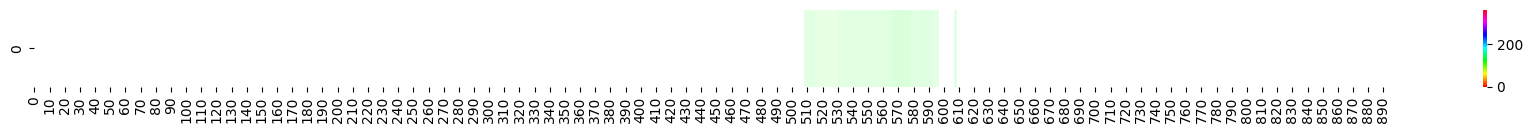

In [22]:
fig,ax = plt.subplots(figsize=(22,1))
g = sns.heatmap(all_ang[n_neu:n_neu+1],cmap=cmap,vmin=0,vmax=360,alpha=all_mag[n_neu:n_neu+1],ax=ax,mask=mask[n_neu:n_neu+1])
#g.tick_params(labelsize=8)
#ax.set_yticks(np.arange(len(all_ang)))
#g.set_ylabel(np.array(np.arange(len(all_ang)),dtype=str))
# ax.set_xlabel(np.arange(-200,len(all_ang[0])-200))
plt.show()

## To test

In [23]:
i_good, i_mua = 1, 1
for i_neuron,cluster in enumerate(data.clustersgroup):
    if cluster == "good":
        i_cluster = i_good
        i_good += 1
        cluster = "neuron"
    else:
        i_cluster = i_mua
        i_mua += 1
    if i_neuron == 14:
        print(4)
    mag,ang,color,orient = get_mag_ang(data,i_neuron)
    all_mag.append(mag)
    all_ang.append(ang)
    all_color.append(color)
    all_orient.append(orient)
    neuron.append(cluster+str(i_cluster)+'_'+s_path[-1][:-3])

ValueError: too many values to unpack (expected 4)

In [ ]:
i_neuron=0
t_before = 200
t_after = 850
in_out='in'
trials_b1 = np.where(np.logical_and(data.trial_error == 0, data.block == 1))[0]
shifts = data.code_samples[
    trials_b1,
    np.where(data.code_numbers[trials_b1] == task_constants.EVENTS_B1["sample_on"])[
        1
    ],
]-t_before

roll_sp = TrialsData.indep_roll(data.sp_samples[trials_b1,i_neuron],shifts=-shifts.astype(int), axis=1)[:,:t_after+t_before]
if np.any(np.isnan(data.neuron_cond)):
    neuron_cond = np.ones(len(data.clustersgroup))
else:
    neuron_cond=data.neuron_cond
task = def_task.create_task_frame(
    condition=data.condition[trials_b1],
    test_stimuli=data.test_stimuli[trials_b1],
    samples_cond=task_constants.SAMPLES_COND,
    neuron_cond = neuron_cond,
)
task = task[(task['i_neuron']==i_neuron)&(task['in_out']==in_out)]

c1_trials = task[task['sample'].str.contains('c1', case=False)]['trial_idx'].values
c5_trials = task[task['sample'].str.contains('c5', case=False)]['trial_idx'].values
o1_trials = task[task['sample'].str.contains('o1', case=False)]['trial_idx'].values
o5_trials = task[task['sample'].str.contains('o5', case=False)]['trial_idx'].values
c0_trials = task[task['sample'].str.contains('c0', case=False)]['trial_idx'].values

win = 100
step = 1
avg_sp = moving_average(data=roll_sp,win=win, step=step)[:,:-win]

c1_sp = avg_sp[c1_trials] 
c5_sp = avg_sp[c5_trials] 
o1_sp = avg_sp[o1_trials] 
o5_sp = avg_sp[o5_trials] 
c0_sp = avg_sp[c0_trials] 

#color = compute_roc_auc(c1_sp,c5_sp)
#orient = compute_roc_auc(o1_sp,o5_sp)
group1 = c1_sp
group2 = c5_sp
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(np.arange(0,1,0.1).reshape(-1, 1))
rng = np.random.default_rng(seed=seed)
#it_seed = rng.integers(low=1, high=2023, size=a.shape[1], dtype=int)
roc_score,p = [],[]
for n_win in np.arange(11,group1.shape[1]):
    g1 = group1[:,n_win]
    g2 = group2[:,n_win]
    # t-test
    p.append(stats.ttest_ind(g1, g2)[1])
    min_fr, max_fr = np.concatenate([g1,g2]).min(),np.concatenate([g1,g2]).max()
    thresholds = np.arange(min_fr,max_fr+0.01,0.01)
    y_g1, y_g2 = np.ones(len(g1)),np.zeros(len(g2))
    score=0.5
    fpr,tpr=[],[]
    for threshold in thresholds:
        g1_y_pred,g2_y_pred = np.zeros(len(g1)),np.zeros(len(g2))
        g1_mask,g2_mask = g1>=threshold,g2>=threshold
        g1_y_pred[g1_mask],g2_y_pred[g2_mask] = 1,1
        tp = sum(np.logical_and(y_g1==1,g1_y_pred==1))
        fn = sum(np.logical_and(y_g1==1,g1_y_pred==0))
        tpr.append(tp/ (tp+fn) )
        fp = sum(np.logical_and(y_g2==0,g2_y_pred==1))
        tn = sum(np.logical_and(y_g2==0,g2_y_pred==0))
        fpr.append(fp/ (fp+tn) )
    if len(fpr) > 1:
        fpr,tpr=np.array(fpr),np.array(tpr)
        idx_sort=fpr.argsort()
        score = metrics.auc(fpr[idx_sort],tpr[idx_sort])
        roc_score.append(score)
    else:
        roc_score.append(score)
roc_score=np.array(roc_score)
roc_score=scaler.transform(roc_score.reshape(-1, 1)).squeeze()

In [ ]:
plt.scatter(all_color[14],all_orient[14])